# Bryan vs Bryan Podcast - Data Analysis and Visualization

In [297]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
import warnings

#visuals
sns.set_theme('notebook', style='dark')
colors = ['#34C0F2','#F73B36']
rating_order = ['PG', 'PG-13', 'TV-14', 'R', 'TV-MA', 'NC-17', 'U' ]
pd.set_option('display.float_format', '{:.2f}'.format)

In [228]:
#set working directory
#os.chdir('C:\\Users\\kraem\\OneDrive\\Data_Science\\Visualization_Project_Podcast\\Data')

os.chdir('C:\\Users\\kraem\\OneDrive\\[04] Data Science\\[01] Projects\\[04] Visualization_Project_Podcast\\Data')

In [229]:
#read in data
df = pd.read_excel('BryanVsBryan_Data.xlsx', sheet_name='Movies', index_col=False)

In [230]:
#clean up some of the columns, round to 2 decimal places
df['Release_Date'] = df['Release_Date'].astype(int)
df['Budget'] = df['Budget'].astype(int)
df.round(2)

,Sort_Order,Episode,Title,Release_Date,Budget,Budget (Millions),Rating,Type,Genre,Sub_Genre,Run_Time_Minutes,Bryan_B_Score,Bryan_W_Score,Score_Difference,Notes
0,1,8,Star Wars: The Last Jedi,2017,317000000,317.00,PG-13,Movie,Sci-Fi,Action,152,6.00,8.50,-2.50,Scores based on conversation
1,2,10,The Blair Witch Project,1999,60000,0.06,R,Movie,Horror,Mystery,81,10.00,10.00,0.00,NaN
2,3,10,Blair Witch 2: Book of Shadows,2000,15000000,15.00,R,Movie,Horror,Adventure,90,8.00,7.00,1.00,NaN
3,4,10,Blair Witch,2016,5000000,5.00,R,Movie,Horror,Mystery,89,5.00,4.50,0.50,Bryan W says 4 or a 5 for this one.
4,5,12,Ghostbusters,1984,30000000,30.00,PG,Movie,Comedy,Fantasy,105,9.00,9.00,0.00,"Scored based on comments, never gave a score"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,197,218,Bad Boys: Ride or Die,2024,100000000,100.00,R,Movie,Action,Comedy,115,7.00,5.50,1.50,NaN
197,198,219,Don't Move,2024,0,0.00,R,Movie,Horror,Thriller,92,5.00,6.50,-1.50,NaN
198,199,220,Scary Movie,2000,19000000,19.00,R,Movie,Parody,Comedy,88,7.30,6.70,0.60,NaN
199,200,221,"Planes, Trains, and Automobiles",1987,15000000,15.00,R,Movie,Comedy,NaN,92,7.00,7.50,-0.50,NaN


## Initial Data Review and Cleanup

In [231]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sort_Order         201 non-null    int64  
 1   Episode            201 non-null    int64  
 2   Title              201 non-null    object 
 3   Release_Date       201 non-null    int64  
 4   Budget             201 non-null    int64  
 5   Budget (Millions)  201 non-null    float64
 6   Rating             201 non-null    object 
 7   Type               201 non-null    object 
 8   Genre              201 non-null    object 
 9   Sub_Genre          180 non-null    object 
 10  Run_Time_Minutes   201 non-null    int64  
 11  Bryan_B_Score      198 non-null    float64
 12  Bryan_W_Score      198 non-null    float64
 13  Score_Difference   201 non-null    float64
 14  Notes              16 non-null     object 
dtypes: float64(4), int64(5), object(6)
memory usage: 23.7+ KB


In [232]:
#see the data
df.head()

,Sort_Order,Episode,Title,Release_Date,Budget,Budget (Millions),Rating,Type,Genre,Sub_Genre,Run_Time_Minutes,Bryan_B_Score,Bryan_W_Score,Score_Difference,Notes
0,1,8,Star Wars: The Last Jedi,2017,317000000,317.00,PG-13,Movie,Sci-Fi,Action,152,6.00,8.50,-2.50,Scores based on conversation
1,2,10,The Blair Witch Project,1999,60000,0.06,R,Movie,Horror,Mystery,81,10.00,10.00,0.00,NaN
2,3,10,Blair Witch 2: Book of Shadows,2000,15000000,15.00,R,Movie,Horror,Adventure,90,8.00,7.00,1.00,NaN
3,4,10,Blair Witch,2016,5000000,5.00,R,Movie,Horror,Mystery,89,5.00,4.50,0.50,Bryan W says 4 or a 5 for this one.
4,5,12,Ghostbusters,1984,30000000,30.00,PG,Movie,Comedy,Fantasy,105,9.00,9.00,0.00,"Scored based on comments, never gave a score"


In [233]:
#drop unneeded columns
df.drop(['Sort_Order', 'Type'], axis=1, inplace=True)

In [234]:
#add new columns

#decade
df['Decade'] = (df['Release_Date'] // 10) * 10

#cumulative score
df['Cumulative_Score'] = df['Bryan_B_Score']+df['Bryan_W_Score']

#movie budget bins
bins = [0, 100_000, 5_000_000, 50_000_000, 250_000_000, float('Inf')]
labels = ['Micro', 'Low', 'Medium', 'Large', 'Mega']
df['Budget_Type'] = pd.cut(df['Budget'], bins=bins, labels=labels)

#genre with sub-genre
df['Specific_Genre'] = df['Genre'] + '-' + df['Sub_Genre']

#budget per point
df['Budget_Per_Point'] = df['Budget']/df['Cumulative_Score']

## High Level Analysis

In [324]:
#number of movies scored
print(f'Bryan vs Bryan has reviewed {len(df)} movies')

#average score
BB_mean = df['Bryan_B_Score'].mean()
BW_mean = df['Bryan_W_Score'].mean()

print(f"Bryan B's average score: {BB_mean:.2f}")
print(f"Bryan W's average score: {BW_mean:.2f}")

Bryan vs Bryan has reviewed 201 movies
Bryan B's average score: 7.11
Bryan W's average score: 7.02


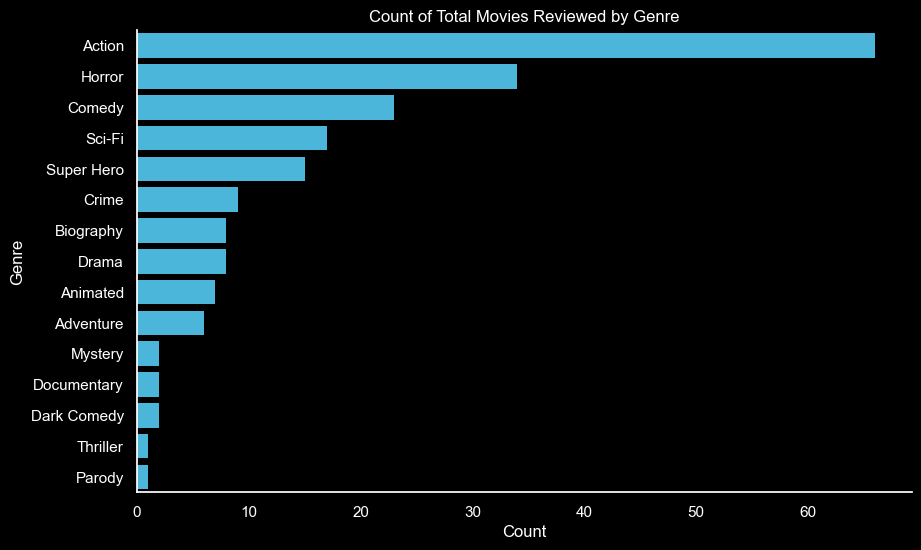

In [236]:
#count by genre
#figure out count plot instead of percentages...might make it easier to visualize
count_genre = df['Genre'].value_counts()
count_genre = count_genre.to_frame().copy()

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(count_genre, y=count_genre.index, x='count', orient='h', linewidth=0, color=colors[0]).set_title('Count of Total Movies Reviewed by Genre')
ax.set(xlabel='Count', ylabel='Genre')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

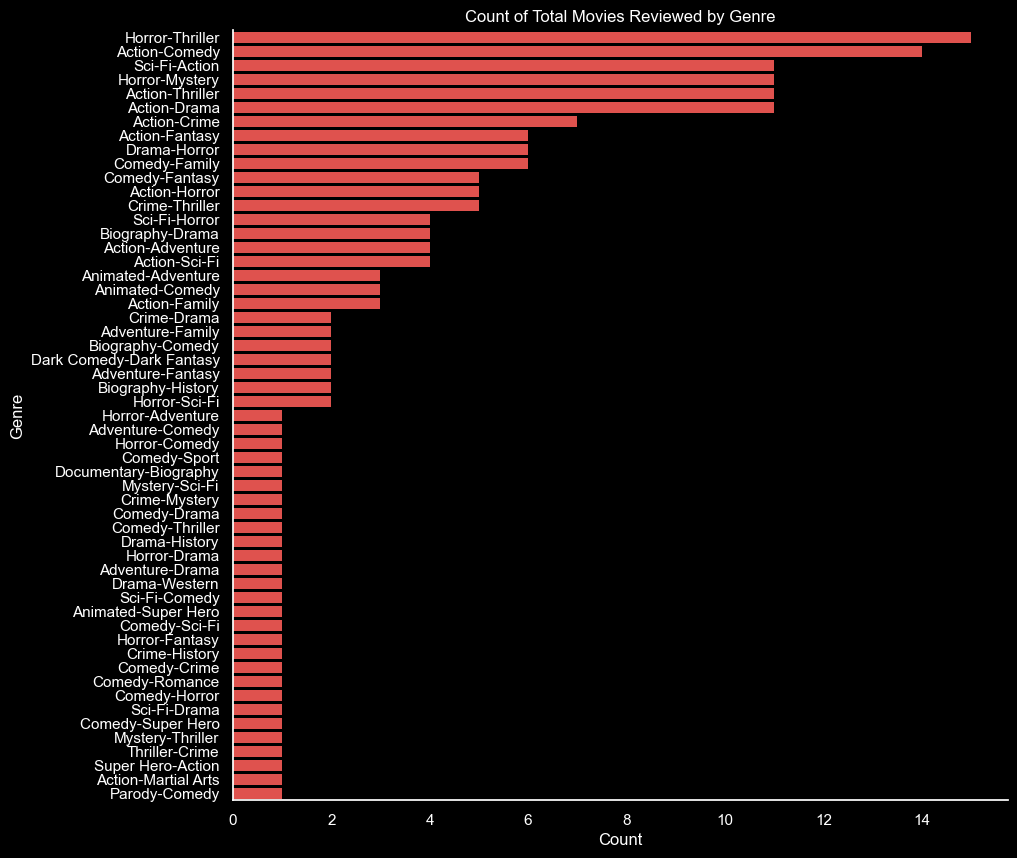

In [237]:
#count by specific genre
#figure out count plot instead of percentages...might make it easier to visualize
count_sp_genre = df['Specific_Genre'].value_counts()
count_sp_genre = count_sp_genre.to_frame().copy()
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(count_sp_genre, y=count_sp_genre.index, x='count', orient='h', linewidth=0, color=colors[1]).set_title('Count of Total Movies Reviewed by Genre')
ax.set(xlabel='Count', ylabel='Genre')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

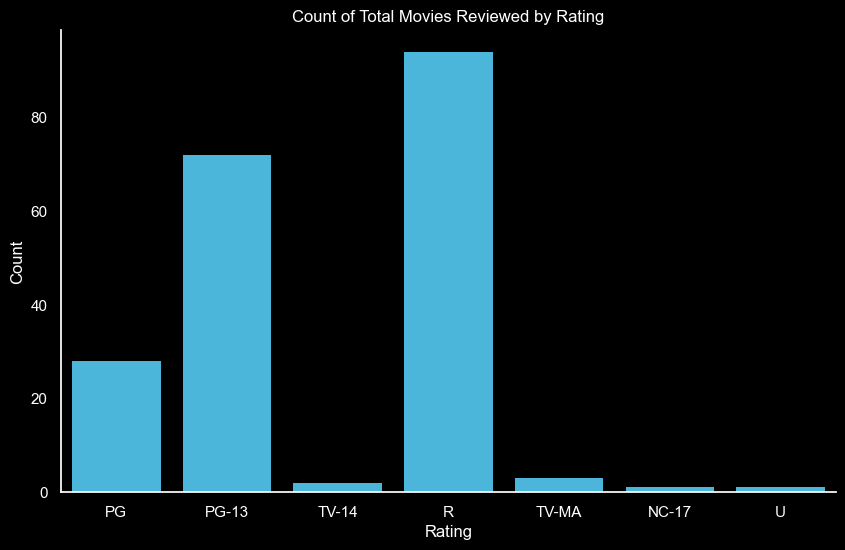

In [238]:
#percentage of movies scored by rating
count_rating = df['Rating'].value_counts()
count_rating = count_rating.to_frame().copy()
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(count_rating, x=count_rating.index, y='count', orient='v', linewidth=0, color=colors[0], order=rating_order).set_title('Count of Total Movies Reviewed by Rating')
ax.set(xlabel='Rating', ylabel='Count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

## Cumulative Score Analysis

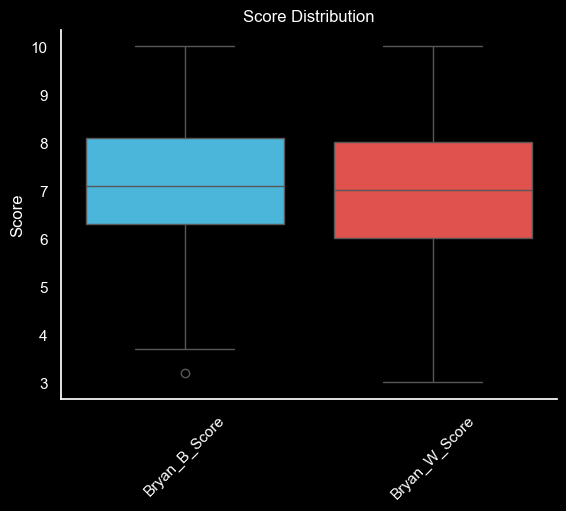

In [239]:
#score comparison
my_pal = {'Bryan_B_Score': colors[0], 'Bryan_W_Score': colors[1]}

ax = sns.boxplot(data=df[['Bryan_B_Score', 'Bryan_W_Score']], palette=my_pal)

#plot
#create palette
plt.style.use('dark_background')
plt.title("Score Distribution")
ax.set(xlabel='', ylabel='Score')
ax.tick_params(axis='x', labelrotation = 45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);


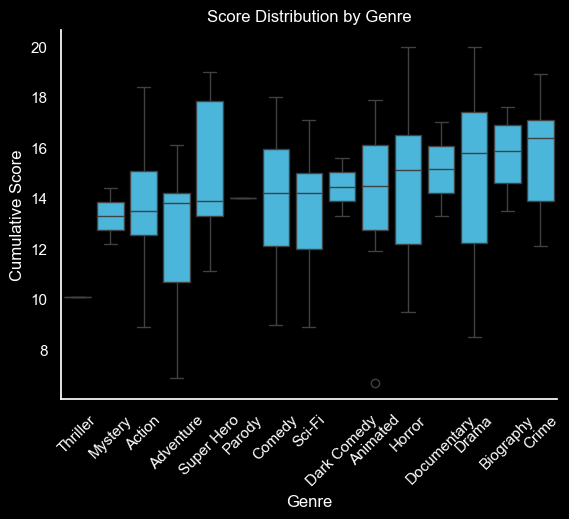

In [240]:
#pivot the data
cumulative_pivot = df.pivot_table(index='Title', columns='Genre',values='Cumulative_Score')

#cumulative score boxplot

#sort cumulative score by mean
sorted_index = cumulative_pivot.median().sort_values().index
df_sorted = cumulative_pivot[sorted_index]

#plot
#create palette
plt.style.use('dark_background')
plt.title("Score Distribution by Genre")
ax = sns.boxplot(data=df_sorted, color=colors[0], orient='v')
ax.set(xlabel='Genre', ylabel='Cumulative Score')
ax.tick_params(axis='x', labelrotation = 45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

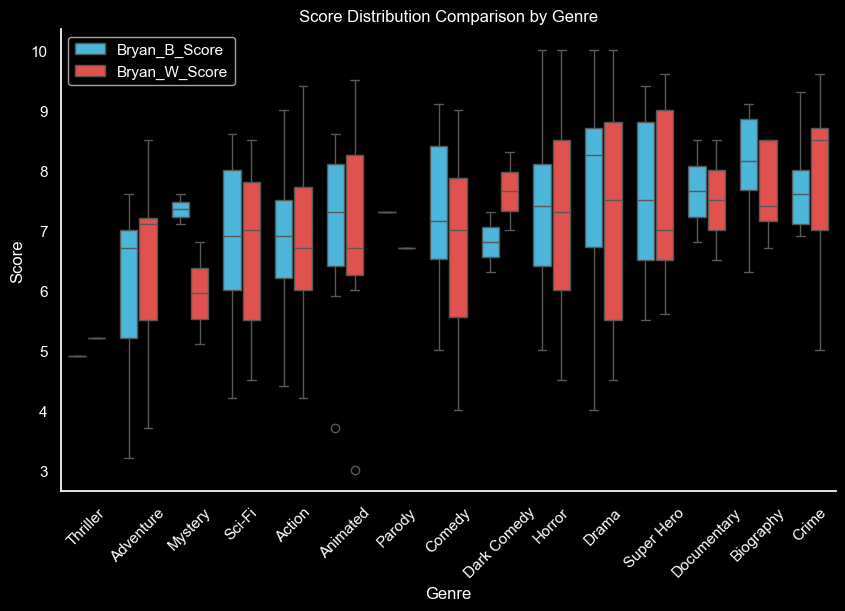

In [241]:
#comparing Bryan B and Bryan W by genre
genre_data=df.melt(id_vars=['Genre'], value_vars=['Bryan_B_Score', 'Bryan_W_Score'],
                 var_name='Bryan', value_name='Score')

#order
order = genre_data.groupby('Genre')['Score'].mean().sort_values().index

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=genre_data, y='Score', x='Genre', hue='Bryan', palette=colors, dodge=True, width=0.75, order=order, gap=0.1)
plt.legend(title='')
plt.title("Score Distribution Comparison by Genre")
ax.tick_params(axis='x', labelrotation = 45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

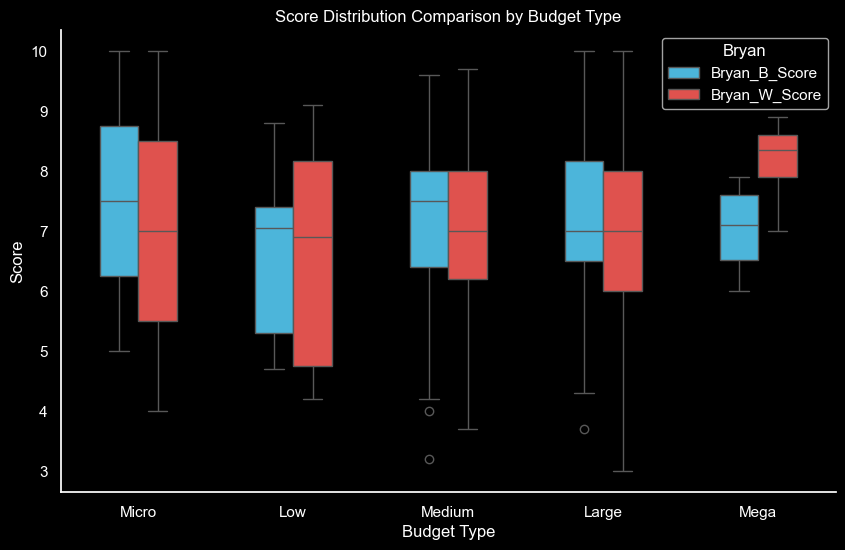

In [242]:
#comparing Bryan B and Bryan W by Budget Type
budget_data=df.melt(id_vars=['Budget_Type'], value_vars=['Bryan_B_Score', 'Bryan_W_Score'],
                 var_name='Bryan', value_name='Score')
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=budget_data, y='Score', x='Budget_Type', hue='Bryan', palette=colors, dodge=True, width=0.5)
plt.title('Score Distribution Comparison by Budget Type')
ax.set(xlabel='Budget Type', ylabel='Score')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

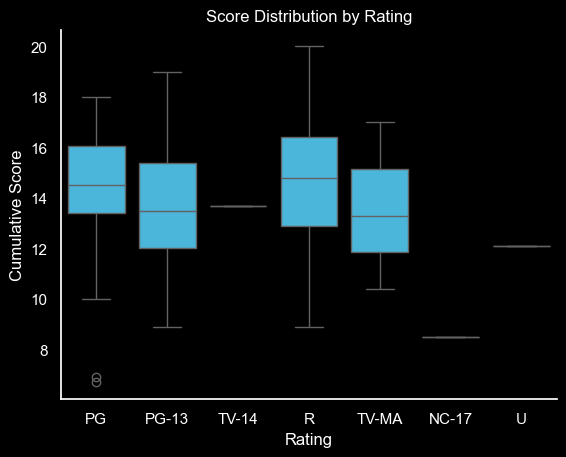

In [243]:
#cumulative score boxplot
cumulative_pivot = df.pivot_table(index='Title', columns='Rating',values='Cumulative_Score')

#sort cumulative score by mean
sorted_index = cumulative_pivot.median().sort_values().index
df_sorted = cumulative_pivot[sorted_index]

#plot
plt.style.use('dark_background')
plt.title("Score Distribution by Rating")
ax = sns.boxplot(data=df_sorted, color=colors[0], orient='v', order=rating_order)
ax.set(xlabel='Rating', ylabel='Cumulative Score')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

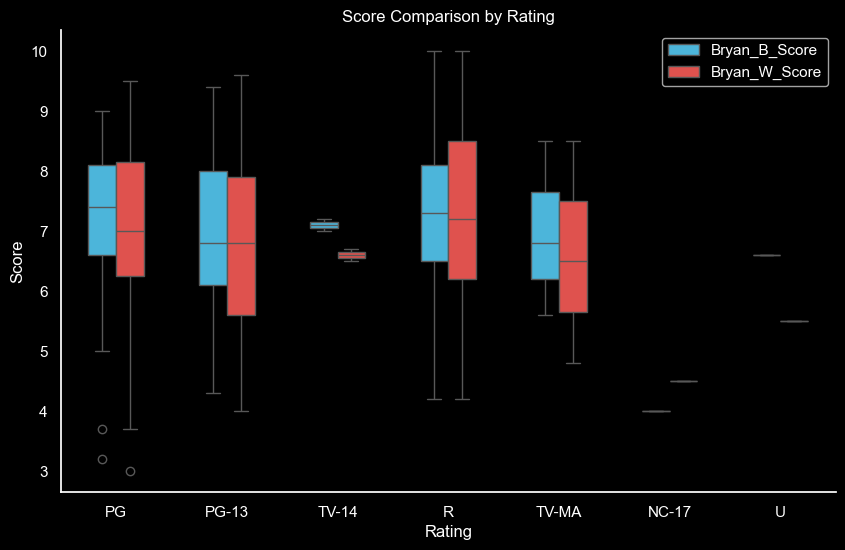

In [244]:
#comparing Bryan B and Bryan W by Rating
plt.style.use('dark_background')
rating_data=df.melt(id_vars=['Rating'], value_vars=['Bryan_B_Score', 'Bryan_W_Score'],
                 var_name='Bryan', value_name='Score')
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=rating_data, y='Score', x='Rating', hue='Bryan', palette=colors, dodge=True, width=0.5, order=rating_order)
plt.title('Score Comparison by Rating')
plt.legend(title='')
ax.set(xlabel='Rating', ylabel='Score')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

## Distribution of Data

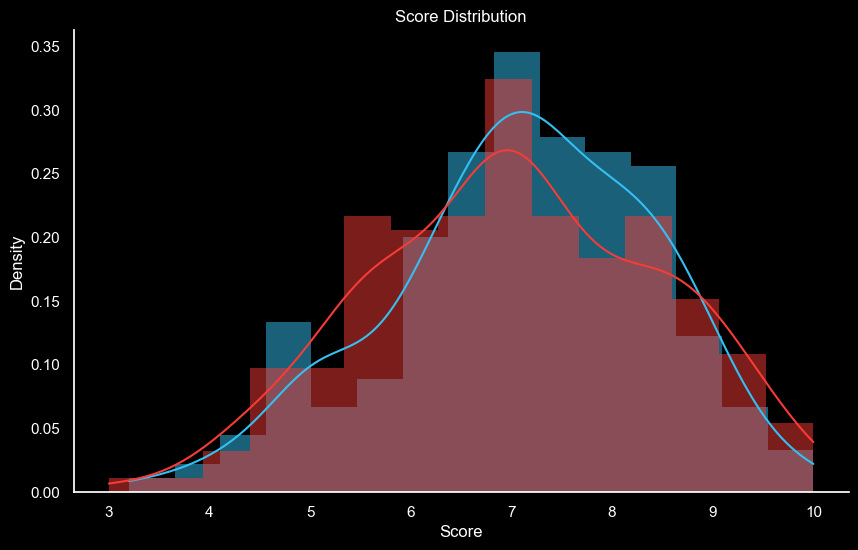

In [245]:
#histogram
fig, ax = plt.subplots(figsize=(10,6))


plt.rcParams['patch.linewidth'] = 0
plt.style.use('dark_background')
plt.title("Score Distribution")

sns.histplot(df['Bryan_B_Score'], kde=True, stat='density', color=colors[0], bins=15)
sns.histplot(df['Bryan_W_Score'], kde=True, stat='density', color=colors[1], bins=15)
ax.set(xlabel='Score', ylabel='Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.show();

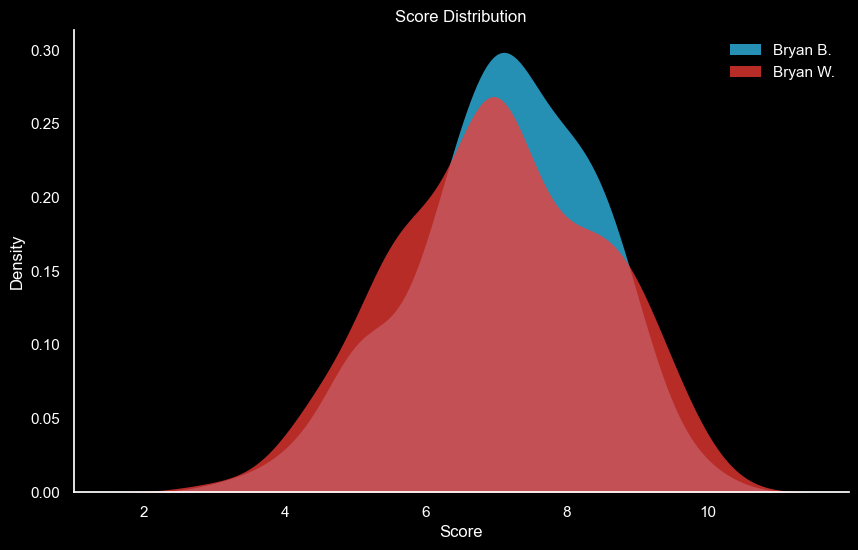

In [246]:
#histogram
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Score Distribution")

sns.kdeplot(df["Bryan_B_Score"], label='Bryan B.', color=colors[0], multiple='stack')
sns.kdeplot(df["Bryan_W_Score"], label='Bryan W.', color=colors[1], multiple='stack')
ax.set(xlabel='Score', ylabel='Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);
plt.legend();

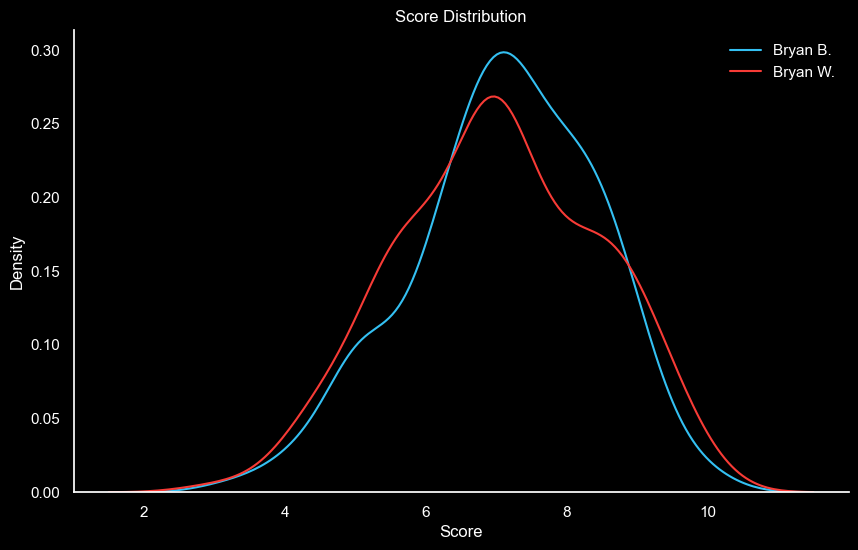

In [247]:
#histogram
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Score Distribution")

sns.kdeplot(df["Bryan_B_Score"], label='Bryan B.', color=colors[0])
sns.kdeplot(df["Bryan_W_Score"], label='Bryan W.', color=colors[1])
ax.set(xlabel='Score', ylabel='Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);
plt.legend();

In [321]:
#ridge plot
#get unique genre values
unique_values = df['Genre'].unique()
#convert to array
genres = unique_values
df_filtered = df[df['Genre'].isin(genres)]

#group by genre and calculate the mean of cumulative score
mean_scores = df.groupby('Genre')['Cumulative_Score'].mean()

# Sort the genres by the mean scores
sorted_genres = mean_scores.sort_values().index.to_numpy()

In [322]:
# Calculate the mean Cumulative_Score for each Genre and sort them
mean_scores = df_filtered.groupby('Genre')['Cumulative_Score'].mean().sort_values()
sorted_genres = mean_scores.index

# Reorder the DataFrame based on sorted genres
df_filtered['Genre'] = pd.Categorical(df_filtered['Genre'], categories=sorted_genres, ordered=True)
df_filtered = df_filtered.sort_values('Genre')

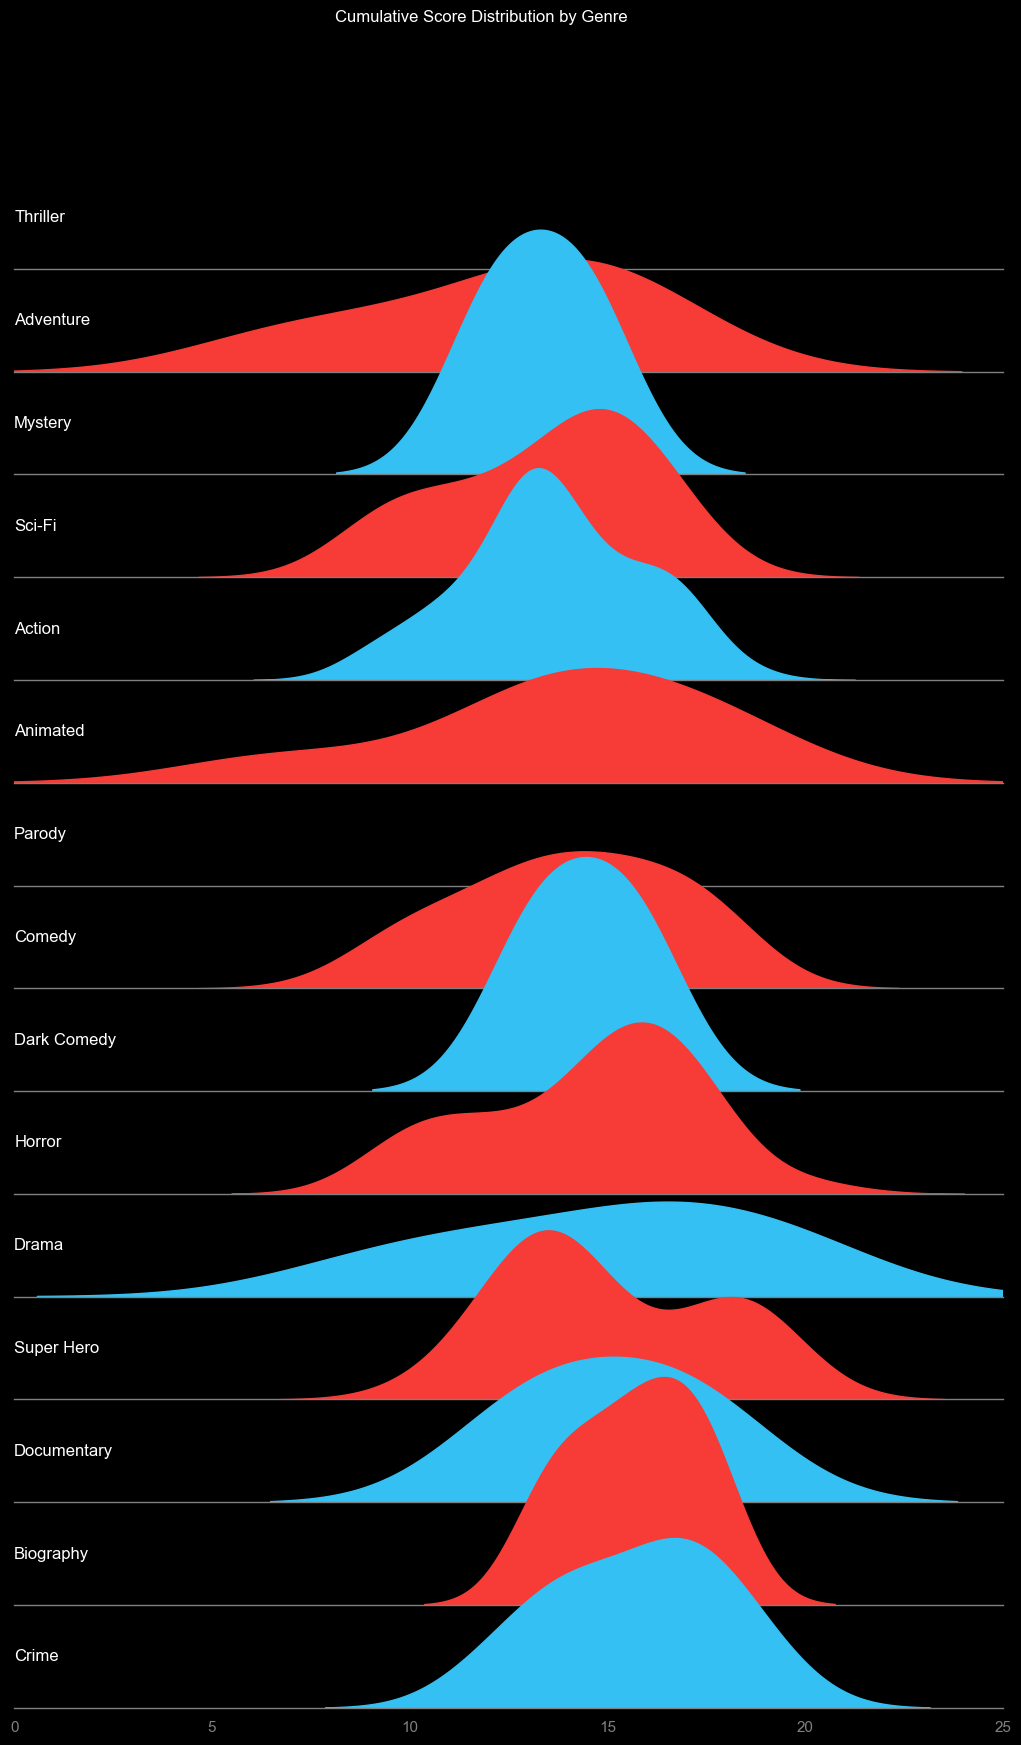

In [323]:
#plot
sns.set_theme(style="dark", rc={"axes.facecolor": '(0, 0, 0, 0)',  'figure.facecolor': 'black', 'axes.linewidth':2})
g = sns.FacetGrid(df_filtered, palette=colors, row="Genre", hue="Genre", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="Cumulative_Score", fill=True, alpha=1)
#g.map_dataframe(sns.kdeplot, x="Cumulative_Score", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color='white', fontsize=12,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Genre")
g.fig.subplots_adjust(hspace=-.6)
g.set_titles("")
g.set_axis_labels("", "")
g.set(yticks=[], xlabel="")
g.despine( left=True)
g.set(xlim=(0, 25))

for ax in g.axes.flat:
    ax.spines['bottom'].set_color('gray') # Change color
    ax.spines['bottom'].set_linewidth(1) # Change linewidth
    ax.xaxis.label.set_color('gray') # Change x-axis label color
    ax.tick_params(axis='x', colors='gray')


plt.suptitle('Cumulative Score Distribution by Genre', y=0.98, color='white', size=12);

In [249]:
#skew and kurtosis of the score distributions
bryanb_skew = df["Bryan_B_Score"].skew()
bryanw_skew = df["Bryan_W_Score"].skew()

print(f'Bryan B has a skew of {bryanb_skew}')
print(f'Bryan W has a skew of {bryanw_skew}')

bryanb_kurt = df["Bryan_B_Score"].kurtosis()
bryanw_kurt = df["Bryan_W_Score"].kurtosis()

print(f'Bryan B has a kurtosis of {bryanb_kurt}')
print(f'Bryan W has a kurtosis of {bryanw_kurt}')


Bryan B has a skew of -0.3650270417054423
Bryan W has a skew of -0.1075565896995074
Bryan B has a kurtosis of -0.14473416824594842
Bryan W has a kurtosis of -0.5285279239019856


## Correlation

In [95]:
correlation = df['Bryan_B_Score'].corr(df['Bryan_W_Score']).round(3)
print(f"The scores for Bryan B. and Bryan W. are {correlation*100}% correlated")

The scores for Bryan B. and Bryan W. are 81.8% correlated


## Scores

In [326]:
#total budget of all movies scored (if budget data was available)
def format_as_score(number):
    return "{:,.2f}".format(number)

#budget calculations
total_score = df['Cumulative_Score'].sum()
average_score = df['Cumulative_Score'].mean()
med_score = df['Cumulative_Score'].median()
max_score = df['Cumulative_Score'].max()
max_title = df[df['Cumulative_Score'] == max_score]['Title']
min_score = df['Cumulative_Score'].min()
min_title = df[df['Cumulative_Score']== min_score]['Title']


#format and print
formatted_total = format_as_score(total_score)
formatted_average = format_as_score(average_score)
formatted_median = format_as_score(med_score)
formatted_max = format_as_score(max_score)
formatted_min = format_as_score(min_score)


print(f"The total scores given for all movies: {formatted_total}")
print(f"The average score for all movies:      {formatted_average}")
print(f"The median score for all movies:       {formatted_median}")
print(f"The maximum score for all movies:      {formatted_max} for {max_title.values[1]} and {max_title.values[0]}")
print(f"The minimum score for all movies:      {formatted_min} for {min_title.values[0]}")

The total scores given for all movies: 2,797.35
The average score for all movies:      14.13
The median score for all movies:       14.00
The maximum score for all movies:      20.00 for Django Unchained and The Blair Witch Project
The minimum score for all movies:      6.70 for Tom and Jerry


## Top 10 Highest Cumulative Scores

In [97]:
#wins by score and budget
df_wins = df[df['Cumulative_Score'] >= 15]
df_wins = df_wins.sort_values(by=['Cumulative_Score','Budget_Per_Point'], ascending=False).head(10).copy()

df_wins['Budget_Per_Point'] = df_wins['Budget_Per_Point'].map('${:,.0f}'.format)
df_wins['Episode'] = df_wins['Episode'].map('{:,.0f}'.format)
df_wins['Budget'] = df_wins['Budget'].map('${:,.0f}'.format)
df_wins['Bryan_B_Score'] = df_wins['Bryan_B_Score'].map('{:,.2f}'.format)
df_wins['Bryan_W_Score'] = df_wins['Bryan_W_Score'].map('{:,.2f}'.format)
df_wins['Cumulative_Score'] = df_wins['Cumulative_Score'].map('{:,.2f}'.format)


df_wins[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score', 'Budget','Budget_Per_Point']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Budget,Budget_Per_Point
148,Django Unchained,10.00,10.00,20.00,"$100,000,000","$5,000,000"
10,The Blair Witch Project,10.00,10.00,20.00,"$60,000","$3,000"
63,The Shining,9.60,9.70,19.30,"$19,000,000","$984,456"
72,Spider Man 2,9.40,9.60,19.00,"$200,000,000","$10,526,316"
126,The Departed,9.30,9.60,18.90,"$90,000,000","$4,761,905"
83,The Dark Night,9.30,9.30,18.60,"$185,000,000","$9,946,237"
83,The Batman,8.90,9.50,18.40,"$185,000,000","$10,054,348"
94,Top Gun: Maverick,9.00,9.40,18.40,"$170,000,000","$9,239,130"
59,Batman,9.00,9.00,18.00,"$35,000,000","$1,944,444"
12,Ghostbusters,9.00,9.00,18.00,"$30,000,000","$1,666,667"


## Top 10 Lowest Cumulative Scores

In [98]:
#lowest cumulative scores
lowest = df[df['Cumulative_Score'] > 0]

#lowest cumulative scores
lowest_score_df = lowest.sort_values(by=['Cumulative_Score'], ascending=False).tail(10).sort_values(by=['Cumulative_Score','Budget'], ascending=True).copy()
lowest_score_df['Budget_Per_Point'] = lowest_score_df['Budget_Per_Point'].map('${:,.0f}'.format)
lowest_score_df['Budget'] = lowest_score_df['Budget'].map('${:,.0f}'.format)
lowest_score_df['Bryan_B_Score'] = lowest_score_df['Bryan_B_Score'].map('{:,.2f}'.format)
lowest_score_df['Bryan_W_Score'] = lowest_score_df['Bryan_W_Score'].map('{:,.2f}'.format)
lowest_score_df['Cumulative_Score'] = lowest_score_df['Cumulative_Score'].map('{:,.2f}'.format)

lowest_score_df[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score','Budget','Budget_Per_Point']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Budget,Budget_Per_Point
30,Tom and Jerry,3.70,3.00,6.70,"$79,000,000","$11,791,045"
189,Mac and Me,3.20,3.70,6.90,"$13,000,000","$1,884,058"
141,Blonde,4.00,4.50,8.50,"$22,000,000","$2,588,235"
181,Cyborg,4.70,4.20,8.90,"$500,000","$56,180"
98,Morbius,4.40,4.50,8.90,"$75,000,000","$8,426,966"
73,The Matrix Resurrections,4.40,4.50,8.90,"$190,000,000","$21,348,315"
185,Troll 2,5.00,4.00,9.00,"$100,000","$11,111"
214,Street Fighter (1994),5.20,4.20,9.40,"$35,000,000","$3,723,404"
166,Jason Goes to Hell,5.00,4.50,9.50,"$3,000,000","$315,789"
10,Blair Witch,5.00,4.50,9.50,"$5,000,000","$526,316"


## Budget

In [99]:
#total budget of all movies scored (if budget data was available)
def format_as_dollar(number):
    return "${:,.0f}".format(number)

#budget calculations
total = df['Budget'].sum()
average = df['Budget'].mean()
med = df['Budget'].median()
max_budget = df['Budget'].max()
max_title = df[df['Budget'] == max_budget]['Title']
min_budget = df['Budget'].min()
min_title = df[df['Budget']== min_budget]['Title']

#format and print
formatted_total = format_as_dollar(total)
formatted_average = format_as_dollar(average)
formatted_median = format_as_dollar(med)
formatted_max = format_as_dollar(max_budget)
formatted_min = format_as_dollar(min_budget)

print(f"The total budget for all movies scored:   {formatted_total}")
print(f"The average budget for all movies scored: {formatted_average}")
print(f"The median budget for all movies scored:  {formatted_median}")
print(f"The maximum budget for all movies scored: {formatted_max} for {max_title.values[0]}")
print(f"The minimum budget for all movies scored: {formatted_min} for {min_title.values[0]}")

The total budget for all movies scored:   $13,672,260,000
The average budget for all movies scored: $68,021,194
The median budget for all movies scored:  $39,000,000
The maximum budget for all movies scored: $350,000,000 for Avatar: Way of Water
The minimum budget for all movies scored: $0 for Fear Street 1994


## Top 10 Highest Budgets

In [100]:
#highest budget
highest_budget = df.sort_values(by=['Budget'], ascending=False).head(10).copy()
highest_budget['Budget_Per_Point'] = highest_budget['Budget_Per_Point'].map('${:,.0f}'.format)
highest_budget['Episode'] = highest_budget['Episode'].map('{:,.0f}'.format)
highest_budget['Budget'] = highest_budget['Budget'].map('${:,.0f}'.format)
highest_budget['Bryan_B_Score'] = highest_budget['Bryan_B_Score'].map('{:,.2f}'.format)
highest_budget['Bryan_W_Score'] = highest_budget['Bryan_W_Score'].map('{:,.2f}'.format)
highest_budget['Cumulative_Score'] = highest_budget['Cumulative_Score'].map('{:,.2f}'.format)

highest_budget[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score','Budget','Budget_Per_Point']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Budget,Budget_Per_Point
124,Avatar: Way of Water,6.70,8.20,14.90,"$350,000,000","$23,489,933"
8,Star Wars: The Last Jedi,6.00,8.50,14.50,"$317,000,000","$21,862,069"
33,Justice League Snyder Cut,7.50,7.00,14.50,"$300,000,000","$20,689,655"
154,Mission Impossible: Dead Reckoning,7.90,8.90,16.80,"$291,000,000","$17,321,429"
119,Black Panther: Wakanda Forever,6.80,6.80,13.60,"$250,000,000","$18,382,353"
111,Thor: Love and Thunder,6.50,6.00,12.50,"$250,000,000","$20,000,000"
144,Guardians of the Galaxy: Volume 3,8.20,7.80,16.00,"$250,000,000","$15,625,000"
184,The Marvels,6.00,7.10,13.10,"$220,000,000","$16,793,893"
20,Tenet,8.00,8.00,16.00,"$205,000,000","$12,812,500"
188,Aquaman and the Lost Kingdom,5.50,5.60,11.10,"$205,000,000","$18,468,468"


## Top 10 Lowest Budgets

In [101]:
#lowest budget
lowest = df[df['Budget'] > 0]
lowest_budget = lowest.sort_values(by='Budget', ascending=False).tail(10).sort_values(by=['Budget','Budget_Per_Point'], ascending=True).copy()

lowest_budget['Budget_Per_Point'] = lowest_budget['Budget_Per_Point'].map('${:,.0f}'.format)
lowest_budget['Episode'] = lowest_budget['Episode'].map('{:,.0f}'.format)
lowest_budget['Budget'] = lowest_budget['Budget'].map('${:,.0f}'.format)
lowest_budget['Bryan_B_Score'] = lowest_budget['Bryan_B_Score'].map('{:,.2f}'.format)
lowest_budget['Bryan_W_Score'] = lowest_budget['Bryan_W_Score'].map('{:,.2f}'.format)
lowest_budget['Cumulative_Score'] = lowest_budget['Cumulative_Score'].map('{:,.2f}'.format)

lowest_budget[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score','Budget','Budget_Per_Point']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Budget,Budget_Per_Point
10,The Blair Witch Project,10.00,10.00,20.00,"$60,000","$3,000"
185,Troll 2,5.00,4.00,9.00,"$100,000","$11,111"
181,Cyborg,4.70,4.20,8.90,"$500,000","$56,180"
169,X,7.40,8.50,15.90,"$1,000,000","$62,893"
90,The Raid: Redemption,6.20,7.00,13.20,"$1,100,000","$83,333"
166,Jason Goes to Hell,5.00,4.50,9.50,"$3,000,000","$315,789"
107,Maggie,7.10,5.50,12.60,"$4,000,000","$317,460"
167,Talk to Me,8.60,9.10,17.70,"$4,500,000","$254,237"
103,Get Out,8.80,8.50,17.30,"$4,500,000","$260,116"
186,The Visit,7.40,7.20,14.60,"$5,000,000","$342,466"


## Top 10 Highest Spent Per Point


In [102]:
#budget and score ratio
mostspent_df = df.sort_values(by='Budget_Per_Point', ascending=False).head(10).copy()
mostspent_df['Budget_Per_Point'] = mostspent_df['Budget_Per_Point'].map('${:,.2f}'.format)
mostspent_df['Episode'] = mostspent_df['Episode'].map('{:,.0f}'.format)
mostspent_df['Budget'] = mostspent_df['Budget'].map('${:,.0f}'.format)
mostspent_df['Bryan_B_Score'] = mostspent_df['Bryan_B_Score'].map('{:,.2f}'.format)
mostspent_df['Bryan_W_Score'] = mostspent_df['Bryan_W_Score'].map('{:,.2f}'.format)
mostspent_df['Cumulative_Score'] = mostspent_df['Cumulative_Score'].map('{:,.2f}'.format)

#most spent on each point
mostspent_df[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score', 'Budget','Budget_Per_Point']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Budget,Budget_Per_Point
124,Avatar: Way of Water,6.70,8.20,14.90,"$350,000,000","$23,489,932.89"
8,Star Wars: The Last Jedi,6.00,8.50,14.50,"$317,000,000","$21,862,068.97"
73,The Matrix Resurrections,4.40,4.50,8.90,"$190,000,000","$21,348,314.61"
33,Justice League Snyder Cut,7.50,7.00,14.50,"$300,000,000","$20,689,655.17"
111,Thor: Love and Thunder,6.50,6.00,12.50,"$250,000,000","$20,000,000.00"
104,The Gray Man,6.00,4.50,10.50,"$200,000,000","$19,047,619.05"
188,Aquaman and the Lost Kingdom,5.50,5.60,11.10,"$205,000,000","$18,468,468.47"
119,Black Panther: Wakanda Forever,6.80,6.80,13.60,"$250,000,000","$18,382,352.94"
154,Mission Impossible: Dead Reckoning,7.90,8.90,16.80,"$291,000,000","$17,321,428.57"
184,The Marvels,6.00,7.10,13.10,"$220,000,000","$16,793,893.13"


# Top 10 Lowest Spent Per Point

In [103]:
#budget and score ratio
filtered_df = df[df['Budget'] != 0]
lowestspend_df = filtered_df.sort_values(by='Budget_Per_Point', ascending=True).head(10).copy()
lowestspend_df['Budget_Per_Point'] = lowestspend_df['Budget_Per_Point'].map('${:,.2f}'.format)
lowestspend_df['Episode'] = lowestspend_df['Episode'].map('{:,.0f}'.format)
lowestspend_df['Budget'] = lowestspend_df['Budget'].map('${:,.0f}'.format)
lowestspend_df['Bryan_B_Score'] = lowestspend_df['Bryan_B_Score'].map('{:,.2f}'.format)
lowestspend_df['Bryan_W_Score'] = lowestspend_df['Bryan_W_Score'].map('{:,.2f}'.format)
lowestspend_df['Cumulative_Score'] = lowestspend_df['Cumulative_Score'].map('{:,.2f}'.format)

#lowest spent on each point
lowestspend_df[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score', 'Budget','Budget_Per_Point']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Budget,Budget_Per_Point
10,The Blair Witch Project,10.00,10.00,20.00,"$60,000","$3,000.00"
185,Troll 2,5.00,4.00,9.00,"$100,000","$11,111.11"
181,Cyborg,4.70,4.20,8.90,"$500,000","$56,179.78"
169,X,7.40,8.50,15.90,"$1,000,000","$62,893.08"
90,The Raid: Redemption,6.20,7.00,13.20,"$1,100,000","$83,333.33"
167,Talk to Me,8.60,9.10,17.70,"$4,500,000","$254,237.29"
103,Get Out,8.80,8.50,17.30,"$4,500,000","$260,115.61"
166,Jason Goes to Hell,5.00,4.50,9.50,"$3,000,000","$315,789.47"
107,Maggie,7.10,5.50,12.60,"$4,000,000","$317,460.32"
186,The Visit,7.40,7.20,14.60,"$5,000,000","$342,465.75"


## Top 10 Flops (sorted by lowest score and budget)

In [104]:
#flops by score and budget
df_flops = df[df['Cumulative_Score'] <= 10]
df_flops = df_flops.sort_values(by=['Cumulative_Score','Budget_Per_Point'], ascending=True).head(10).copy()
df_flops['Budget_Per_Point'] = df_flops['Budget_Per_Point'].map('${:,.2f}'.format)
df_flops['Episode'] = df_flops['Episode'].map('{:,.0f}'.format)
df_flops['Budget'] = df_flops['Budget'].map('${:,.0f}'.format)
df_flops['Bryan_B_Score'] = df_flops['Bryan_B_Score'].map('{:,.2f}'.format)
df_flops['Bryan_W_Score'] = df_flops['Bryan_W_Score'].map('{:,.2f}'.format)
df_flops['Cumulative_Score'] = df_flops['Cumulative_Score'].map('{:,.2f}'.format)

df_flops[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score', 'Budget', 'Budget_Per_Point']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Budget,Budget_Per_Point
30,Tom and Jerry,3.70,3.00,6.70,"$79,000,000","$11,791,044.78"
189,Mac and Me,3.20,3.70,6.90,"$13,000,000","$1,884,057.97"
141,Blonde,4.00,4.50,8.50,"$22,000,000","$2,588,235.29"
181,Cyborg,4.70,4.20,8.90,"$500,000","$56,179.78"
98,Morbius,4.40,4.50,8.90,"$75,000,000","$8,426,966.29"
73,The Matrix Resurrections,4.40,4.50,8.90,"$190,000,000","$21,348,314.61"
185,Troll 2,5.00,4.00,9.00,"$100,000","$11,111.11"
214,Street Fighter (1994),5.20,4.20,9.40,"$35,000,000","$3,723,404.26"
166,Jason Goes to Hell,5.00,4.50,9.50,"$3,000,000","$315,789.47"
10,Blair Witch,5.00,4.50,9.50,"$5,000,000","$526,315.79"


## Score Analysis

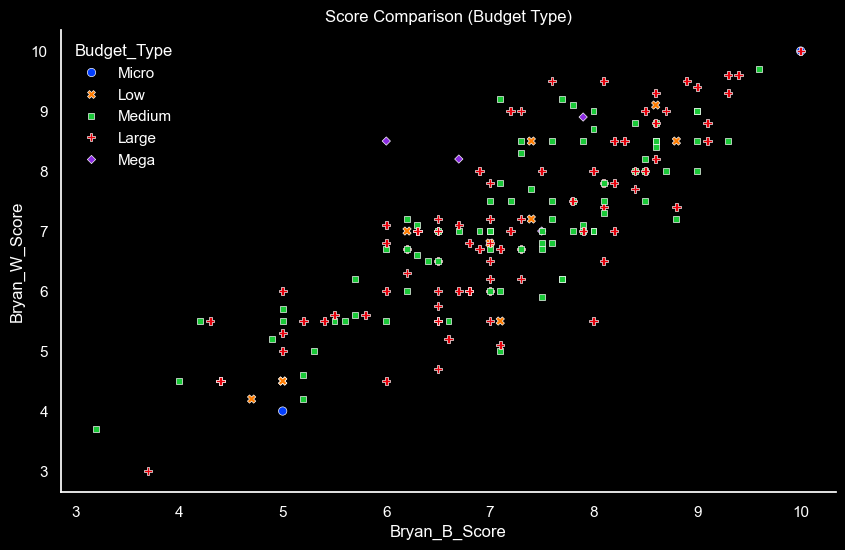

In [105]:
#scatter plot of budget and score
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df, x="Bryan_B_Score", y="Bryan_W_Score", hue='Budget_Type', palette='bright', style='Budget_Type')
plt.title('Score Comparison (Budget Type)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

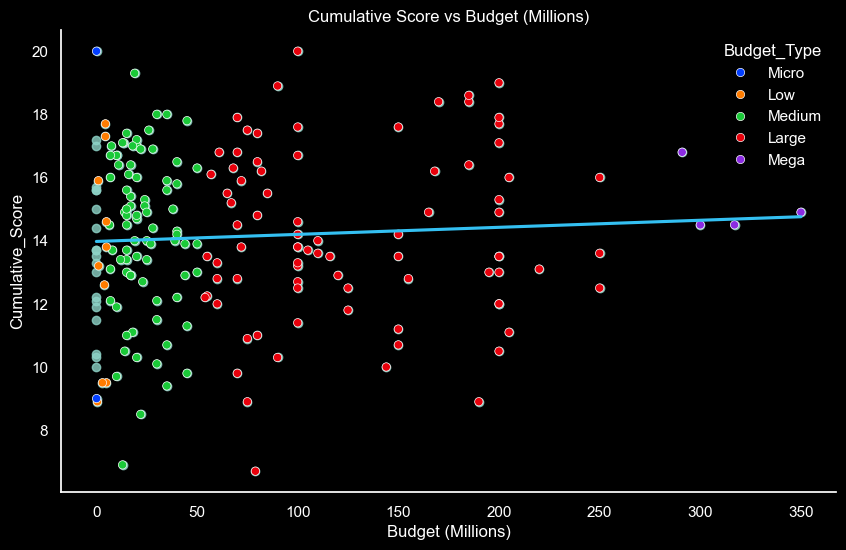

In [106]:
#scatter plot of budget type and score
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Cumulative Score vs Budget (Millions)')
sns.regplot(x=df['Budget (Millions)'], y=df['Cumulative_Score'], ci=False, line_kws={'color':colors[0]})
sns.scatterplot(data=df, x="Budget (Millions)", y="Cumulative_Score", hue='Budget_Type', palette='bright')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

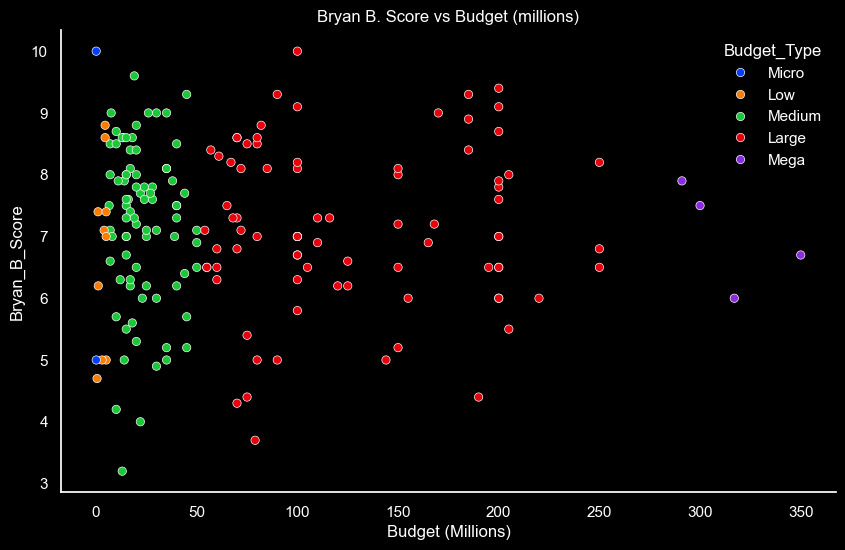

In [107]:
#scatter plot of budget type and score
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Bryan B. Score vs Budget (millions)")
sns.scatterplot(data=df, x="Budget (Millions)", y="Bryan_B_Score", hue='Budget_Type', palette='bright')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

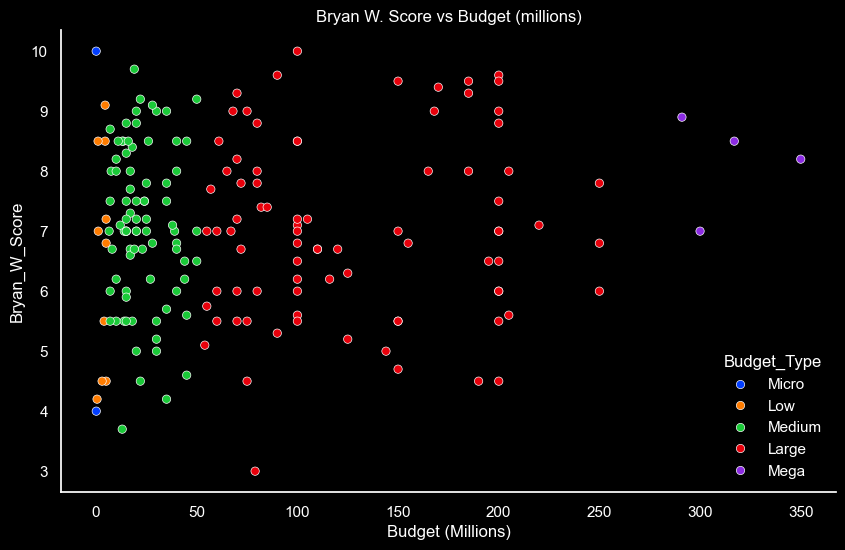

In [108]:
#scatter plot of budget type and score
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Bryan W. Score vs Budget (millions)")
sns.scatterplot(data=df, x="Budget (Millions)", y="Bryan_W_Score", hue='Budget_Type', palette='bright')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

## Year Analysis

In [109]:
#year data description
df["Release_Date"].describe()

count    201.00
mean    2011.57
std       13.91
min     1978.00
25%     1998.00
50%     2021.00
75%     2022.00
max     2024.00
Name: Release_Date, dtype: float64

In [110]:
#simple count of reviews by decade
df.groupby('Decade').size()

Decade
1970      1
1980     21
1990     32
2000     14
2010     25
2020    108
dtype: int64

In [111]:
average_score_per_decade =  df.groupby('Decade')['Cumulative_Score'].mean()
average_score_per_decade

Decade
1970   13.50
1980   14.40
1990   13.79
2000   15.51
2010   14.33
2020   13.96
Name: Cumulative_Score, dtype: float64

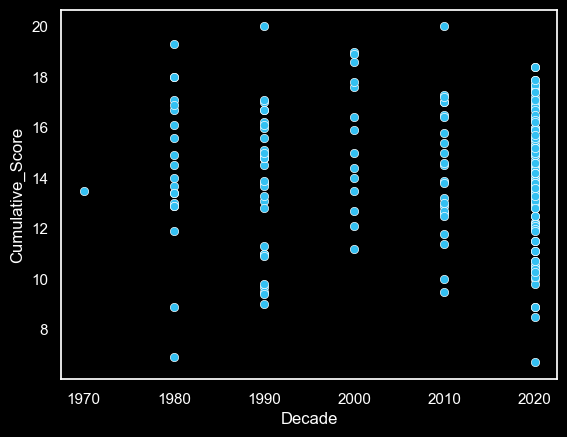

In [112]:
sns.scatterplot(data=df, x="Decade", y="Cumulative_Score", color=colors[0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

<Axes: xlabel='Decade', ylabel='Cumulative_Score'>

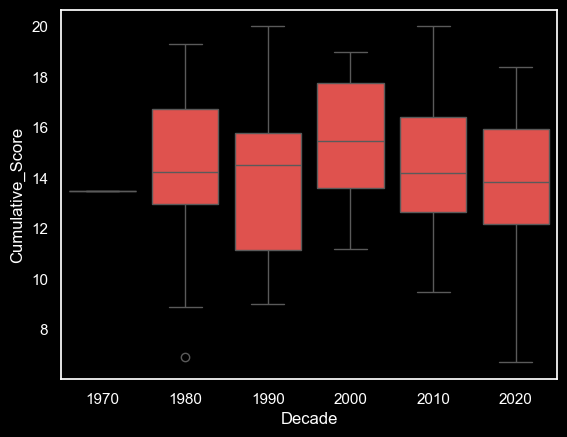

In [113]:
#boxplot by decade
sns.boxplot(data=df,x="Decade",y='Cumulative_Score', color=colors[1])

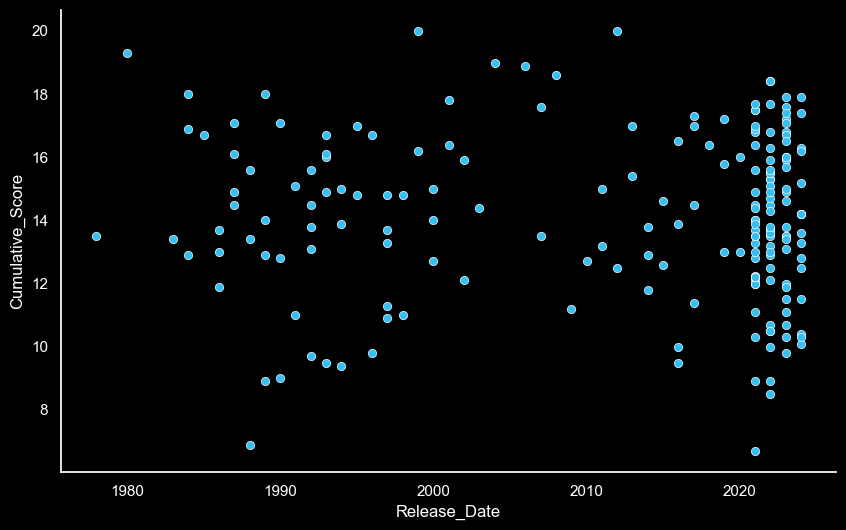

In [114]:
#scatter plot of release year and score
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df, x="Release_Date", y="Cumulative_Score", color=colors[0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

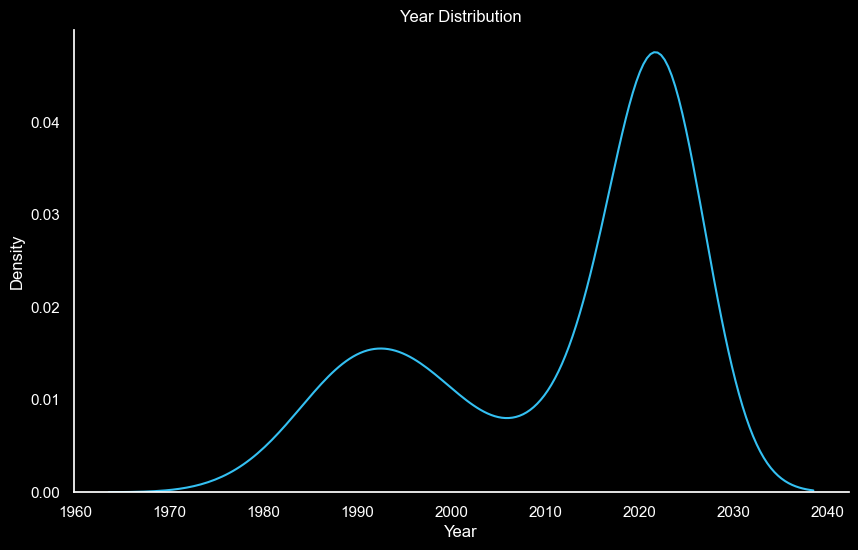

In [115]:
#histogram
fig, ax = plt.subplots(figsize=(10,6))
plt.title("Year Distribution")

sns.kdeplot(df["Release_Date"], color=colors[0])
ax.set(xlabel='Year', ylabel='Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

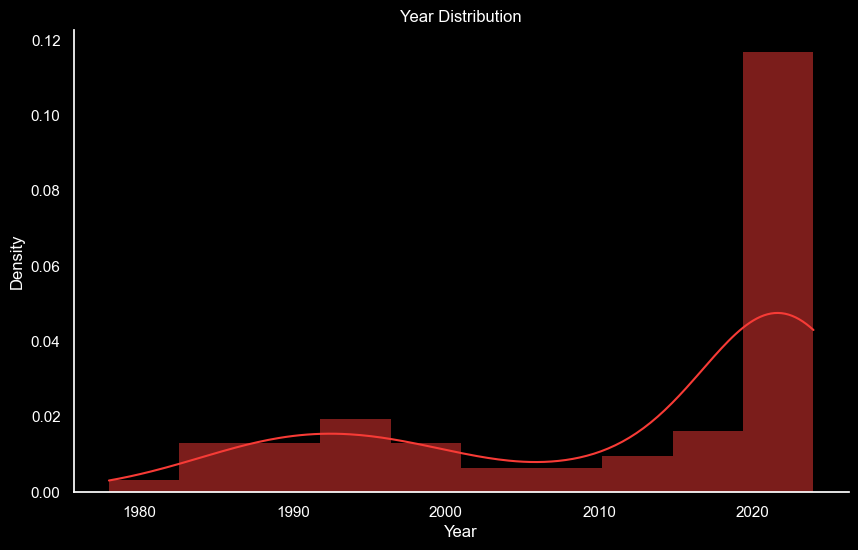

In [116]:
#histogram
fig, ax = plt.subplots(figsize=(10,6))

#do one with the bars and do one that's just the line
plt.rcParams['patch.linewidth'] = 0
plt.style.use('dark_background')
plt.title("Year Distribution")

sns.histplot(df['Release_Date'], kde=True, stat='density', color=colors[1], bins=10)
ax.set(xlabel='Year', ylabel='Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.show();

## Shortest Runtime (minutes)

In [117]:
#shortest run time
shortest = df.sort_values(by='Run_Time_Minutes', ascending=True).head(10).copy()

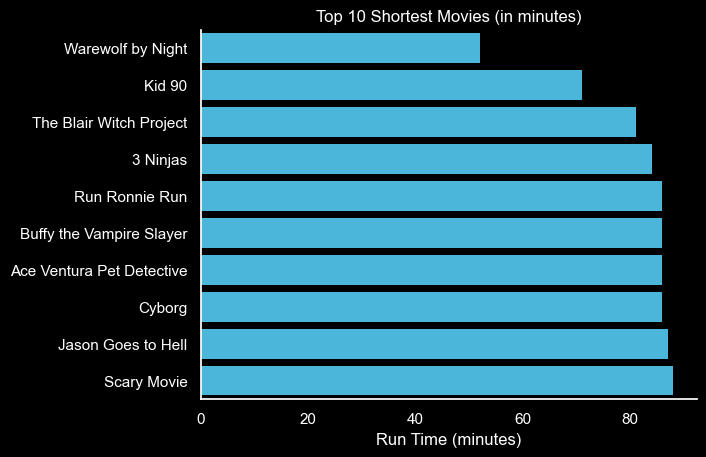

In [118]:
#shortest movies
ax = sns.barplot(shortest, x="Run_Time_Minutes", y="Title", orient="y", color=colors[0])
plt.title('Top 10 Shortest Movies (in minutes)')
ax.set(xlabel='Run Time (minutes)', ylabel='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

## Longest Runtime (minutes)

In [119]:
#longest run time
longest = df.sort_values(by='Run_Time_Minutes', ascending=False).head(10).copy()

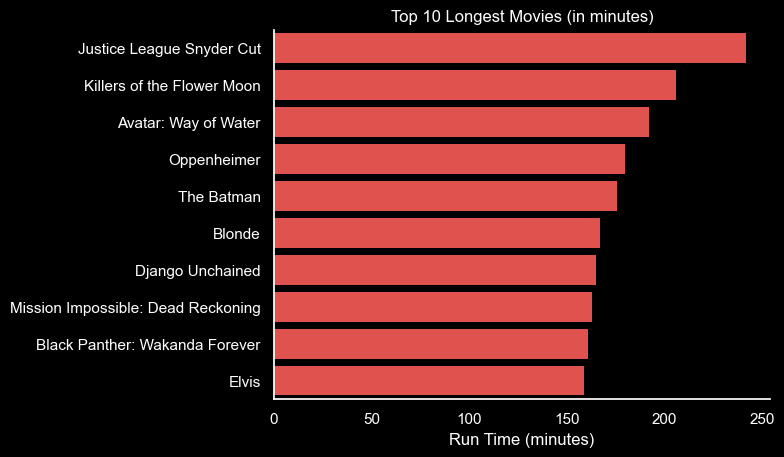

In [120]:
#longest movies
ax = sns.barplot(longest, x="Run_Time_Minutes", y="Title", orient="y", color=colors[1])
plt.title('Top 10 Longest Movies (in minutes)')
ax.set(xlabel='Run Time (minutes)', ylabel='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);

## Largest Score Differences (Bryan B. higher)

In [121]:
#biggest differences
bigdiff_df = df.sort_values(by=['Score_Difference','Budget'],ascending=False).head(10).copy()

bigdiff_df['Budget_Per_Point'] = bigdiff_df['Budget_Per_Point'].map('${:,.2f}'.format)
bigdiff_df['Episode'] = bigdiff_df['Episode'].map('{:,.0f}'.format)
bigdiff_df['Budget'] = bigdiff_df['Budget'].map('${:,.0f}'.format)
bigdiff_df['Bryan_B_Score'] = bigdiff_df['Bryan_B_Score'].map('{:,.2f}'.format)
bigdiff_df['Bryan_W_Score'] = bigdiff_df['Bryan_W_Score'].map('{:,.2f}'.format)
bigdiff_df['Cumulative_Score'] = bigdiff_df['Cumulative_Score'].map('{:,.2f}'.format)
bigdiff_df['Score_Difference'] = bigdiff_df['Score_Difference'].map('{:,.2f}'.format)

bigdiff_df[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score', 'Score_Difference','Budget']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Score_Difference,Budget
34,Transformers,8.00,5.50,13.50,2.50,"$150,000,000"
27,The Little Things,7.10,5.00,12.10,2.10,"$30,000,000"
55,Reminiscence,7.10,5.10,12.20,2.00,"$54,000,000"
195,X-Men Origins: Wolverine,6.50,4.70,11.20,1.80,"$150,000,000"
131,Knock at the Cabin,8.80,7.20,16.00,1.60,"$20,000,000"
140,Super Mario Bros,8.10,6.50,14.60,1.60,"$100,000,000"
77,Short Circuit 2,7.50,5.90,13.40,1.60,"$15,000,000"
107,Maggie,7.10,5.50,12.60,1.60,"$4,000,000"
104,The Gray Man,6.00,4.50,10.50,1.50,"$200,000,000"
218,Bad Boys: Ride or Die,7.00,5.50,12.50,1.50,"$100,000,000"


## Movies Bryan and Bryan Agree On (Same Score, sorted by highest score first)

In [122]:
#smallest differences
same_score = df[df['Score_Difference'] == 0].sort_values(by=['Cumulative_Score'], ascending=False).copy()

same_score['Budget_Per_Point'] = same_score['Budget_Per_Point'].map('${:,.2f}'.format)
same_score['Episode'] = same_score['Episode'].map('{:,.0f}'.format)
same_score['Budget'] = same_score['Budget'].map('${:,.0f}'.format)
same_score['Bryan_B_Score'] = same_score['Bryan_B_Score'].map('{:,.2f}'.format)
same_score['Bryan_W_Score'] = same_score['Bryan_W_Score'].map('{:,.2f}'.format)
same_score['Cumulative_Score'] = same_score['Cumulative_Score'].map('{:,.2f}'.format)
same_score['Score_Difference'] = same_score['Score_Difference'].map('{:,.2f}'.format)

same_score[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score', 'Score_Difference','Budget']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Score_Difference,Budget
10,The Blair Witch Project,10.00,10.00,20.00,0.00,"$60,000"
148,Django Unchained,10.00,10.00,20.00,0.00,"$100,000,000"
83,The Dark Night,9.30,9.30,18.60,0.00,"$185,000,000"
12,Ghostbusters,9.00,9.00,18.00,0.00,"$30,000,000"
59,Batman,9.00,9.00,18.00,0.00,"$35,000,000"
70,Jim and Andy: The Great Beyond,8.50,8.50,17.00,0.00,$0
20,Tenet,8.00,8.00,16.00,0.00,"$205,000,000"
44,The Conjuring: The Devil Made Me Do It,7.00,7.00,14.00,0.00,"$39,000,000"
12,Ghosbusters 2,7.00,7.00,14.00,0.00,"$25,000,000"
119,Black Panther: Wakanda Forever,6.80,6.80,13.60,0.00,"$250,000,000"


## Biggest Differences (no matter who had the higher score)

In [123]:
#biggest difference absolute value
df['Difference_AV'] = abs(df['Score_Difference']) #absolute value
diff_df = df.sort_values(by=['Difference_AV'], ascending=False).head(20).copy()

diff_df['Budget_Per_Point'] = diff_df['Budget_Per_Point'].map('${:,.2f}'.format)
diff_df['Episode'] = diff_df['Episode'].map('{:,.0f}'.format)
diff_df['Budget'] = diff_df['Budget'].map('${:,.0f}'.format)
diff_df['Bryan_B_Score'] = diff_df['Bryan_B_Score'].map('{:,.2f}'.format)
diff_df['Bryan_W_Score'] = diff_df['Bryan_W_Score'].map('{:,.2f}'.format)
diff_df['Cumulative_Score'] = diff_df['Cumulative_Score'].map('{:,.2f}'.format)
diff_df['Score_Difference'] = diff_df['Score_Difference'].map('{:,.2f}'.format)
diff_df['Difference_AV'] = diff_df['Difference_AV'].map('{:,.2f}'.format)

diff_df[['Episode','Title','Bryan_B_Score', 'Bryan_W_Score','Cumulative_Score', 'Score_Difference', 'Difference_AV','Budget']].style.hide(axis="index")

Episode,Title,Bryan_B_Score,Bryan_W_Score,Cumulative_Score,Score_Difference,Difference_AV,Budget
8,Star Wars: The Last Jedi,6.00,8.50,14.50,-2.50,2.50,"$317,000,000"
34,Transformers,8.00,5.50,13.50,2.50,2.50,"$150,000,000"
27,The Little Things,7.10,5.00,12.10,2.10,2.10,"$30,000,000"
193,Civil War,7.10,9.20,16.30,-2.10,2.10,"$50,000,000"
55,Reminiscence,7.10,5.10,12.20,2.00,2.00,"$54,000,000"
168,Killers of the Flower Moon,7.60,9.50,17.10,-1.90,1.90,"$200,000,000"
199,Furiosa: A Mad Max Saga,7.20,9.00,16.20,-1.80,1.80,"$168,000,000"
195,X-Men Origins: Wolverine,6.50,4.70,11.20,1.80,1.80,"$150,000,000"
103,Nope,7.30,9.00,16.30,-1.70,1.70,"$68,000,000"
131,Knock at the Cabin,8.80,7.20,16.00,1.60,1.60,"$20,000,000"


## Top 20 Biggest Score Differences (sorted by Bryan B. Scores)

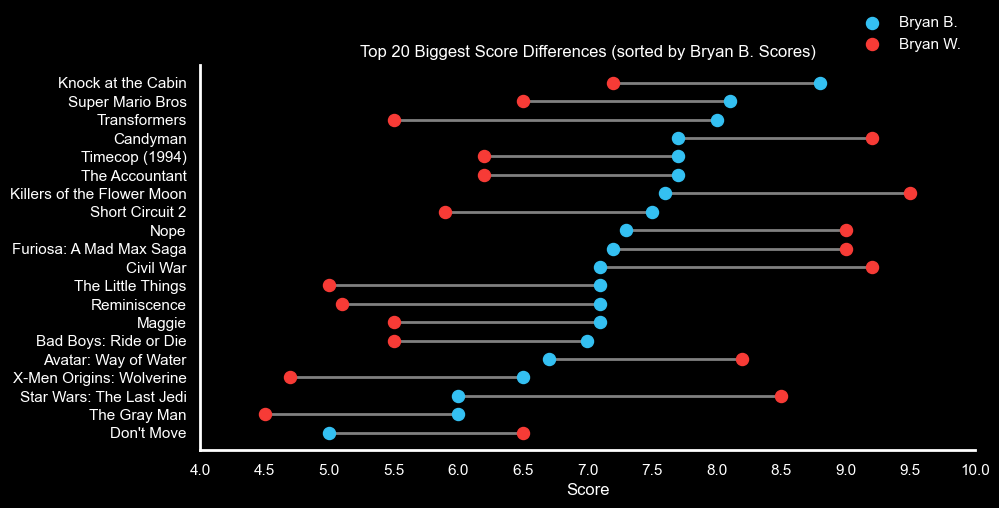

In [327]:
#data shows where Bryan B. was higher
diff_df['Bryan_B_Score'] = diff_df['Bryan_B_Score'].astype(float)
diff_df['Bryan_W_Score'] = diff_df['Bryan_W_Score'].astype(float)
diff_df['Cumulative_Score'] = diff_df['Cumulative_Score'].astype(float)
diff_df['Score_Difference'] = diff_df['Score_Difference'].astype(float)
diff_df['Difference_AV'] = diff_df['Difference_AV'].astype(float)

diff_df.sort_values(by=['Bryan_B_Score','Difference_AV'], inplace=True)
plt.style.use('dark_background')
my_range = range(1,len(diff_df)+1)
fig, ax = plt.subplots(figsize=(10,5))
plt.hlines(y=my_range, xmin=diff_df['Bryan_W_Score'],xmax=diff_df['Bryan_B_Score'], color='gray', lw=2)
plt.scatter(diff_df['Bryan_B_Score'], my_range, color=colors[0], s=75, label='Bryan B.', zorder=3)
plt.scatter(diff_df['Bryan_W_Score'], my_range, color=colors[1], s=75, label='Bryan W.', zorder=3)

plt.title("Top 20 Biggest Score Differences (sorted by Bryan B. Scores)")
plt.legend(ncol=1, bbox_to_anchor=(1.,1.), loc='lower right', frameon=False)
plt.yticks(my_range, diff_df['Title'])
plt.xlabel('Score')
plt.xticks(np.arange(4,10.5, step=0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);
#plt.xticks(rotation=45);  # Rotate x-axis labels for better readability

## Top 20 Biggest Score Differences (sorted by Bryan W. Scores)

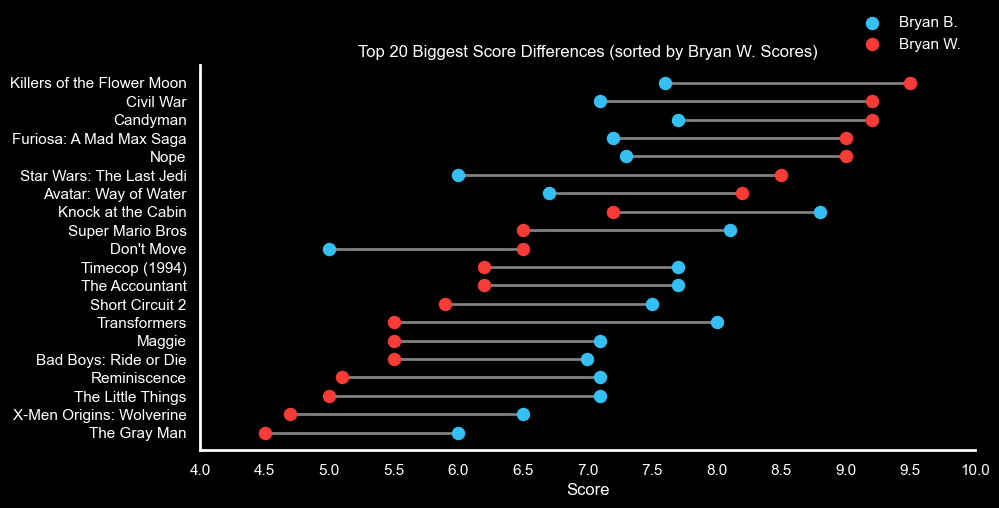

In [328]:
#data shows where Byran W. was higher

diff_df.sort_values(by=['Bryan_W_Score','Difference_AV'], inplace=True)
plt.style.use('dark_background')
my_range = range(1,len(diff_df)+1)
fig, ax = plt.subplots(figsize=(10,5))
plt.hlines(y=my_range, xmin=diff_df['Bryan_B_Score'],xmax=diff_df['Bryan_W_Score'], color='gray', lw=2)
plt.scatter(diff_df['Bryan_B_Score'], my_range, color=colors[0], s=75, label='Bryan B.', zorder=3)
plt.scatter(diff_df['Bryan_W_Score'], my_range, color=colors[1], s=75, label='Bryan W.', zorder=3)

plt.title("Top 20 Biggest Score Differences (sorted by Bryan W. Scores)")
plt.legend(ncol=1, bbox_to_anchor=(1.,1.), loc='lower right', frameon=False)
plt.yticks(my_range, diff_df['Title'])
plt.xlabel('Score')
plt.xticks(np.arange(4,10.5, step=0.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True);
#plt.xticks(rotation=45);  # Rotate x-axis labels for better readability

## Bryan B's Top 10 Movies

In [126]:
#Bryan B Top 10
df.sort_values(by=['Bryan_B_Score', 'Budget'], ascending=False).head(10).round(2)

,Episode,Title,Release_Date,Budget,Budget (Millions),Rating,Genre,Sub_Genre,Run_Time_Minutes,Bryan_B_Score,Bryan_W_Score,Score_Difference,Notes,Decade,Cumulative_Score,Budget_Type,Specific_Genre,Budget_Per_Point,Difference_AV
125,148,Django Unchained,2012,100000000,100.00,R,Drama,Western,165,10.00,10.00,0.00,NaN,2010,20.00,Large,Drama-Western,5000000.00,0.00
1,10,The Blair Witch Project,1999,60000,0.06,R,Horror,Mystery,81,10.00,10.00,0.00,NaN,1990,20.00,Micro,Horror-Mystery,3000.00,0.00
45,63,The Shining,1980,19000000,19.00,R,Drama,Horror,144,9.60,9.70,-0.10,NaN,1980,19.30,Medium,Drama-Horror,984455.96,0.10
54,72,Spider Man 2,2004,200000000,200.00,PG-13,Super Hero,NaN,127,9.40,9.60,-0.20,NaN,2000,19.00,Large,NaN,10526315.79,0.20
66,83,The Dark Night,2008,185000000,185.00,PG-13,Super Hero,NaN,152,9.30,9.30,0.00,Mentioned in this episode,2000,18.60,Large,NaN,9946236.56,0.00
105,126,The Departed,2006,90000000,90.00,R,Crime,Thriller,151,9.30,9.60,-0.30,NaN,2000,18.90,Large,Crime-Thriller,4761904.76,0.30
137,160,Training Day,2001,45000000,45.00,R,Crime,Thriller,122,9.30,8.50,0.80,NaN,2000,17.80,Medium,Crime-Thriller,2528089.89,0.80
185,207,Deadpool and Wolverine,2024,200000000,200.00,R,Comedy,Super Hero,127,9.10,8.80,0.30,NaN,2020,17.90,Large,Comedy-Super Hero,11173184.36,0.30
96,117,American Gangster,2007,100000000,100.00,R,Biography,Drama,157,9.10,8.50,0.60,NaN,2000,17.60,Large,Biography-Drama,5681818.18,0.60
76,94,Top Gun: Maverick,2022,170000000,170.00,PG-13,Action,Drama,130,9.00,9.40,-0.40,NaN,2020,18.40,Large,Action-Drama,9239130.43,0.40


## Bryan W's Top 10 Movies

In [127]:
#Bryan W Top 10
df.sort_values(by=['Bryan_W_Score', 'Budget'], ascending=False).head(10).round(2)

,Episode,Title,Release_Date,Budget,Budget (Millions),Rating,Genre,Sub_Genre,Run_Time_Minutes,Bryan_B_Score,Bryan_W_Score,Score_Difference,Notes,Decade,Cumulative_Score,Budget_Type,Specific_Genre,Budget_Per_Point,Difference_AV
125,148,Django Unchained,2012,100000000,100.00,R,Drama,Western,165,10.00,10.00,0.00,NaN,2010,20.00,Large,Drama-Western,5000000.00,0.00
1,10,The Blair Witch Project,1999,60000,0.06,R,Horror,Mystery,81,10.00,10.00,0.00,NaN,1990,20.00,Micro,Horror-Mystery,3000.00,0.00
45,63,The Shining,1980,19000000,19.00,R,Drama,Horror,144,9.60,9.70,-0.10,NaN,1980,19.30,Medium,Drama-Horror,984455.96,0.10
54,72,Spider Man 2,2004,200000000,200.00,PG-13,Super Hero,NaN,127,9.40,9.60,-0.20,NaN,2000,19.00,Large,NaN,10526315.79,0.20
105,126,The Departed,2006,90000000,90.00,R,Crime,Thriller,151,9.30,9.60,-0.30,NaN,2000,18.90,Large,Crime-Thriller,4761904.76,0.30
146,168,Killers of the Flower Moon,2023,200000000,200.00,R,Crime,History,206,7.60,9.50,-1.90,NaN,2020,17.10,Large,Crime-History,11695906.43,1.90
65,83,The Batman,2022,185000000,185.00,PG-13,Super Hero,NaN,176,8.90,9.50,-0.60,NaN,2020,18.40,Large,NaN,10054347.83,0.60
143,166,Spiderman: Across the Spiderverse,2023,150000000,150.00,PG,Animated,Super Hero,140,8.10,9.50,-1.40,NaN,2020,17.60,Large,Animated-Super Hero,8522727.27,1.40
76,94,Top Gun: Maverick,2022,170000000,170.00,PG-13,Action,Drama,130,9.00,9.40,-0.40,NaN,2020,18.40,Large,Action-Drama,9239130.43,0.40
66,83,The Dark Night,2008,185000000,185.00,PG-13,Super Hero,NaN,152,9.30,9.30,0.00,Mentioned in this episode,2000,18.60,Large,NaN,9946236.56,0.00
